Metin, duygu analizine odaklanmaktadır ve özellikle IMDb inceleme veri kümesi üzerinde çalışmaktadır. Bu veri kümesi, duygu analizi için kullanılabilecek metinleri içermektedir.

Duygu analizi yapmak için önceden eğitilmiş GloVe kelime vektörlerini kullanmak önerilmektedir. Bu vektörler, kelimelerin anlamsal temsillerini içerir ve metinlerin analizi için faydalıdır.

Bir çift yönlü RNN modeli (BiRNN) kullanılarak, metin dizileri sabit uzunluktaki kategorilere dönüştürülür. Bu model, her kelimenin GloVe temsilini alır, metin dizisini bir çift yönlü LSTM ile kodlar, ve sonunda metni "pozitif" ve "negatif" duygulara sınıflandırır.

Metinde, bu BiRNN modelinin nasıl tanımlandığı ve eğitildiği gösterilmektedir. Ayrıca, önceden eğitilmiş kelime vektörlerinin GloVe'dan nasıl yüklendiği de açıklanmaktadır.

Son olarak, eğitilmiş modelin kullanımı gösterilmektedir. Örnek cümlelerin duygularını tahmin etmek için bu modeli kullanabilirsiniz.

Özetle, bu metin, duygu analizi için önceden eğitilmiş kelime vektörlerini ve çift yönlü RNN'leri kullanarak duygu analizi yapmanın nasıl gerçekleştirileceğini anlatıyor.

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [21]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Çift yönlü bir RNN elde etmek için `bidirectional` (çift yönlü)
        # öğesini True olarak ayarlayın
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        """The shape of inputs is (batch size, sequence length).
        As LSTM requires its input's first dimension to be the temporal dimension, the input is transposed before obtaining the token representations. 
        The output has a shape of (sequence length, batch size, word vector size)."""
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        """Returns the hidden states of the last layer of the LSTM at different time steps.
        The shape of outputs is (sequence length, batch size, 2 * hidden unit count)."""
        outputs, _ = self.encoder(embeddings)
        """Concatenate the hidden states at the first and last time steps as the input to the fully connected layer. 
        The shape is (batch size, 4 * hidden unit count)."""
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [22]:
#Duygu analizi için tek bir metni temsil etmek üzere iki gizli katman içeren çift yönlü bir RNN oluşturalım.
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights)

BiRNN(
  (embedding): Embedding(49346, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

Aşağıda önceden eğitilmiş 100 boyutlu (embed_size ile tutarlı olması gerekir) kelime dağarcığındaki belirteçler için GloVe gömmelerini yüklüyoruz.

Embed size, bir kelimenin vektör temsilinin boyutudur. Bu vektör, kelimenin anlamını ve bağlamını temsil eder.

Örneğin, "köpek" kelimesinin 100 boyutlu bir vektör temsili varsa, bu vektör, "köpek" kelimesinin bir köpek, bir hayvan ve bir evcil hayvan olduğunu temsil edebilir.

In [23]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [24]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [25]:
"""Bu kodun amacı, net modelinin embedding katmanının ağırlıklarını, önceden eğitilmiş bir embedding matrisinden yapılandırmaktır. 
Bu, modelin daha hızlı bir şekilde eğitilmesine ve daha iyi sonuçlar üretmesine yardımcı olabilir."""
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

# Çift yönlü RNN'leri eğitiyoruz

In [26]:
devices = [torch.device('cpu')]

loss 0.456, train acc 0.792, test acc 0.832
23.8 examples/sec on [device(type='cpu')]


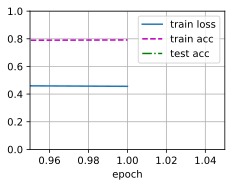

In [28]:
lr, num_epochs = 0.01, 1
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [29]:
def predict_sentiment(net, vocab, sequence):
    """Bir metin dizisinin duygusunu tahmin edin."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [30]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [31]:
predict_sentiment(net, vocab, 'this movie is terrible')

'negative'